In [1]:
import warnings
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.ensemble import (AdaBoostClassifier, BaggingClassifier, GradientBoostingClassifier,
RandomForestClassifier, VotingClassifier, HistGradientBoostingClassifier)

from sklearn.feature_selection import SelectKBest, f_regression, RFE, RFECV
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder, MinMaxScaler, PolynomialFeatures

from sklearn.model_selection import (train_test_split, KFold, cross_val_score, GridSearchCV,
StratifiedKFold, learning_curve, cross_val_predict, cross_validate,
permutation_test_score, validation_curve, StratifiedKFold, RandomizedSearchCV)

from sklearn.metrics import (accuracy_score, cohen_kappa_score, confusion_matrix, mean_squared_error, r2_score,
root_mean_squared_error, recall_score, roc_auc_score, roc_curve, mean_absolute_error, auc, classification_report)

warnings.filterwarnings('ignore') 

In [17]:
df = pd.read_csv('counterfeit_transactions.csv', engine='pyarrow')

In [18]:
df.head()

,transaction_id,customer_id,transaction_date,customer_age,customer_location,quantity,unit_price,total_amount,payment_method,shipping_speed,customer_history_orders,discount_applied,discount_percentage,shipping_cost,delivery_time_days,refund_requested,velocity_flag,geolocation_mismatch,device_fingerprint_new,involves_counterfeit
0,TXN_957334,CUST_11907,2024-10-12 03:52:13,22,JP,1,199.66,199.66,Debit Card,Express,17,False,0.0,5.39,26,False,False,False,False,False
1,TXN_246397,CUST_27641,2024-08-18 00:36:57,62,DE,4,116.01,464.03,PayPal,Express,36,False,0.0,8.18,25,False,False,False,False,False
2,TXN_403072,CUST_78628,2024-08-19 22:21:30,75,DE,1,42.04,42.04,Credit Card,Priority,21,False,0.0,8.61,27,False,False,False,False,False
3,TXN_848560,CUST_98579,2025-04-16 18:49:39,56,BR,3,147.69,443.08,Credit Card,Standard,14,True,48.7,17.00,26,False,False,False,False,False
4,TXN_270817,CUST_67519,2024-10-06 13:30:52,19,IN,4,40.70,162.80,PayPal,Priority,48,False,0.0,20.53,1,False,False,True,False,False


In [29]:
df['customer_id'].value_counts()

customer_id
CUST_23163    3
CUST_23487    2
CUST_35463    2
CUST_48026    2
CUST_45271    2
             ..
CUST_23427    1
CUST_54116    1
CUST_41856    1
CUST_85805    1
CUST_47783    1
Name: count, Length: 2953, dtype: int64

In [30]:
# Check for duplicates
df['customer_id'].duplicated().sum() 

47

In [28]:
# Drop for duplicates
df['customer_id'].drop_duplicates(inplace=True)

In [31]:
# drop 'transaction_id', 'customer_id', and 'transaction_date'
df.drop(columns=['transaction_id','customer_id','transaction_date','quantity', 'unit_price'], axis=1, inplace=True)

In [32]:
df.head()

,customer_age,customer_location,total_amount,payment_method,shipping_speed,customer_history_orders,discount_applied,discount_percentage,shipping_cost,delivery_time_days,refund_requested,velocity_flag,geolocation_mismatch,device_fingerprint_new,involves_counterfeit
0,22,JP,199.66,Debit Card,Express,17,False,0.0,5.39,26,False,False,False,False,False
1,62,DE,464.03,PayPal,Express,36,False,0.0,8.18,25,False,False,False,False,False
2,75,DE,42.04,Credit Card,Priority,21,False,0.0,8.61,27,False,False,False,False,False
3,56,BR,443.08,Credit Card,Standard,14,True,48.7,17.00,26,False,False,False,False,False
4,19,IN,162.80,PayPal,Priority,48,False,0.0,20.53,1,False,False,True,False,False


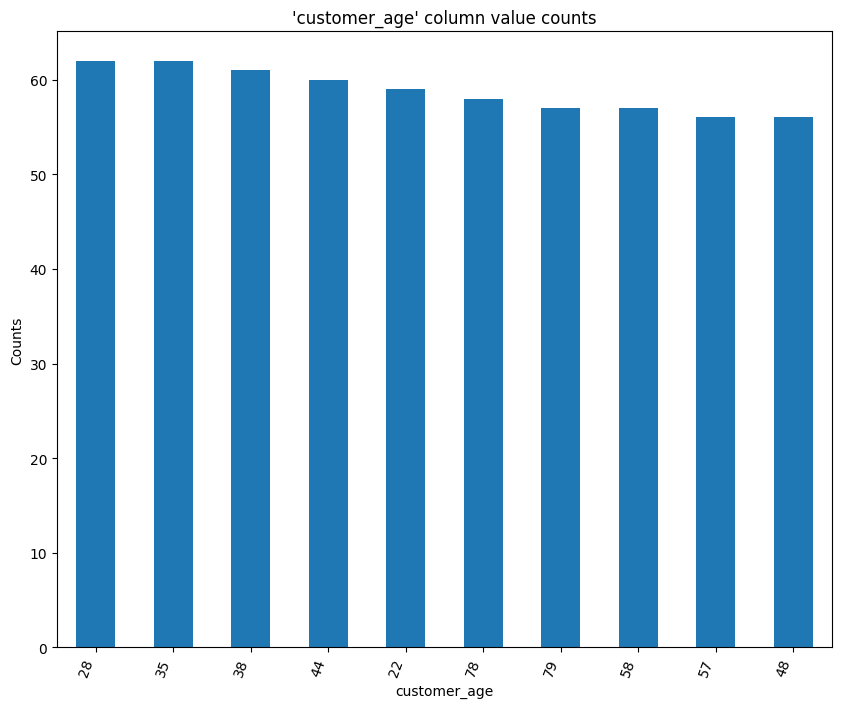

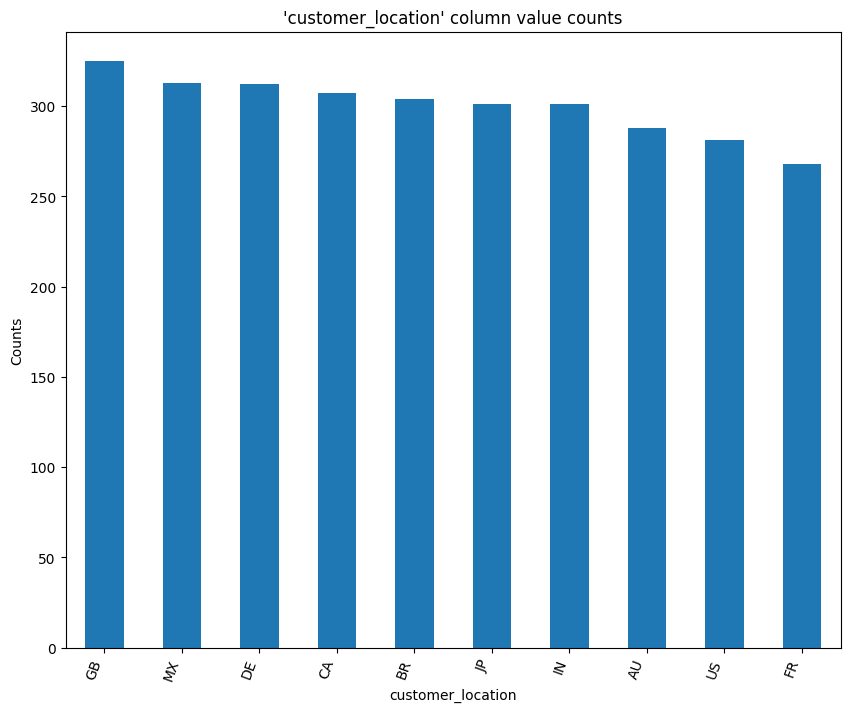

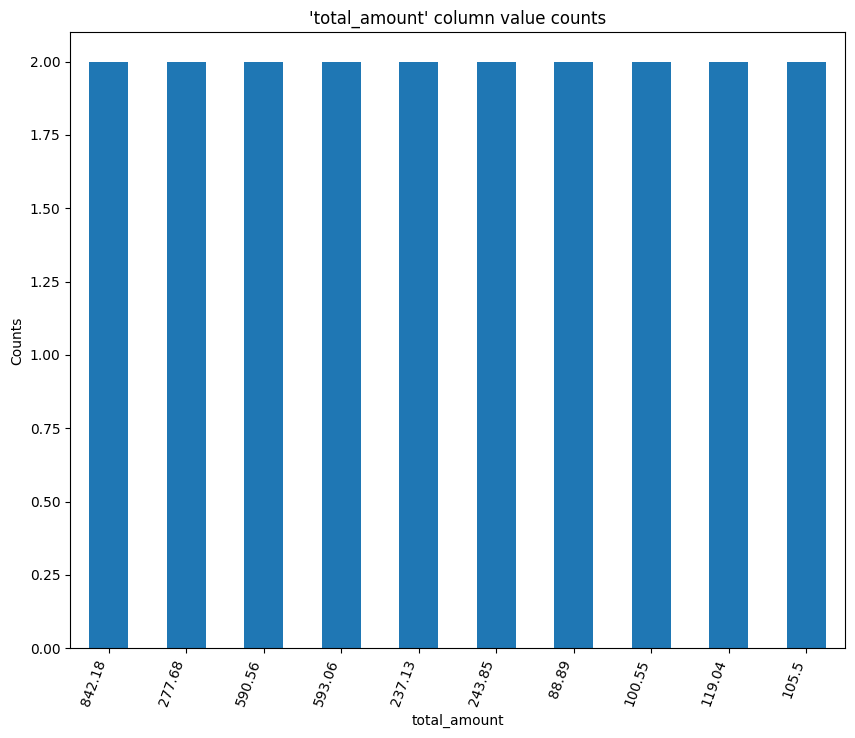

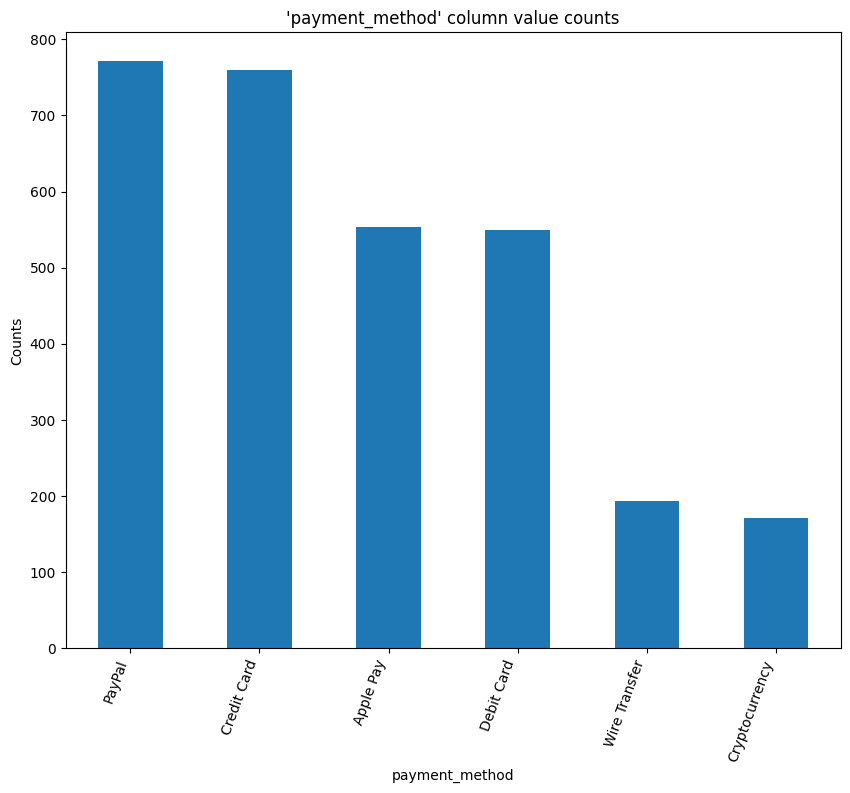

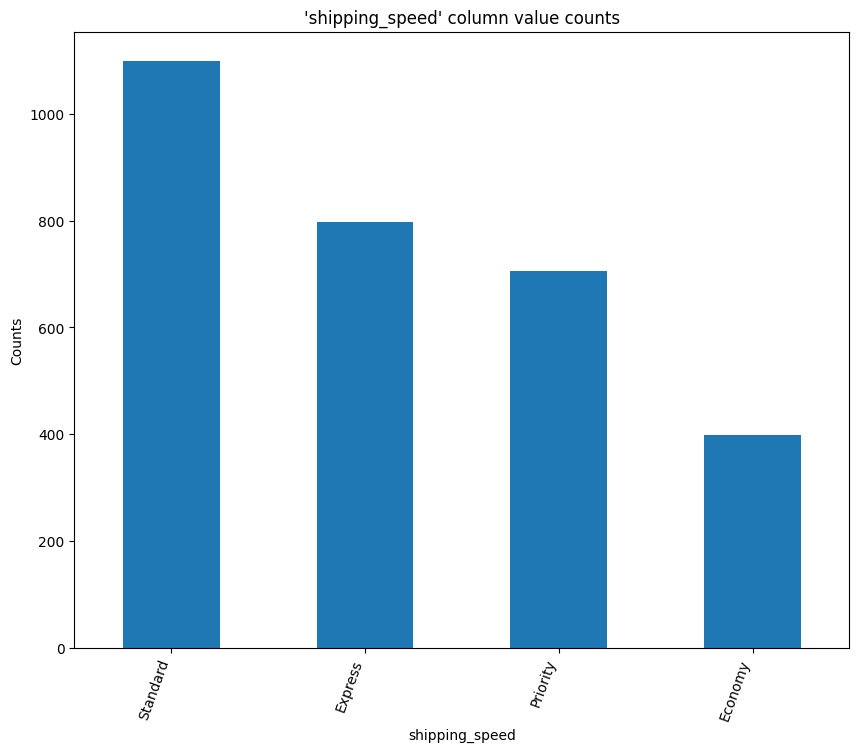

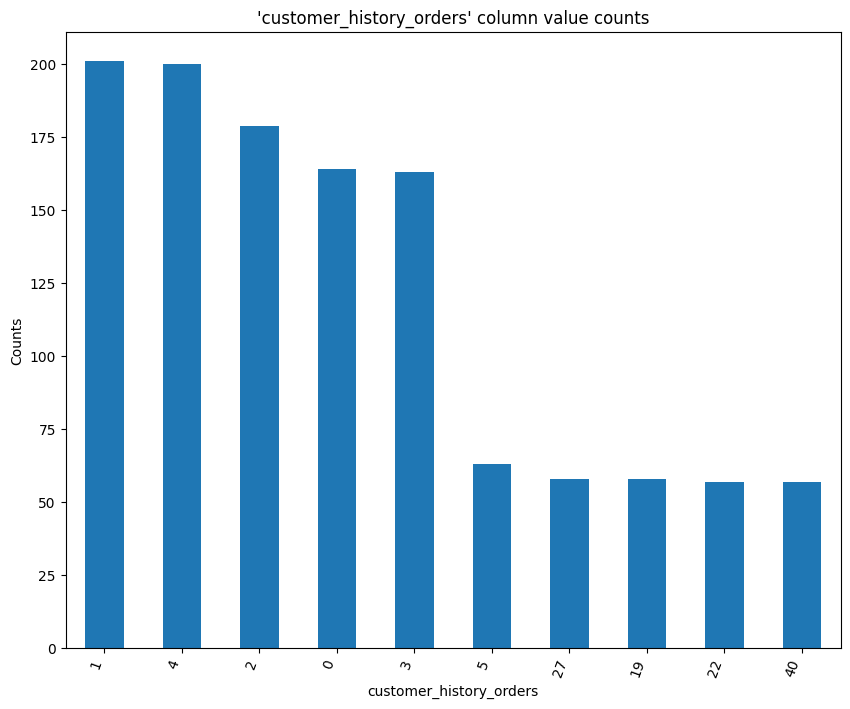

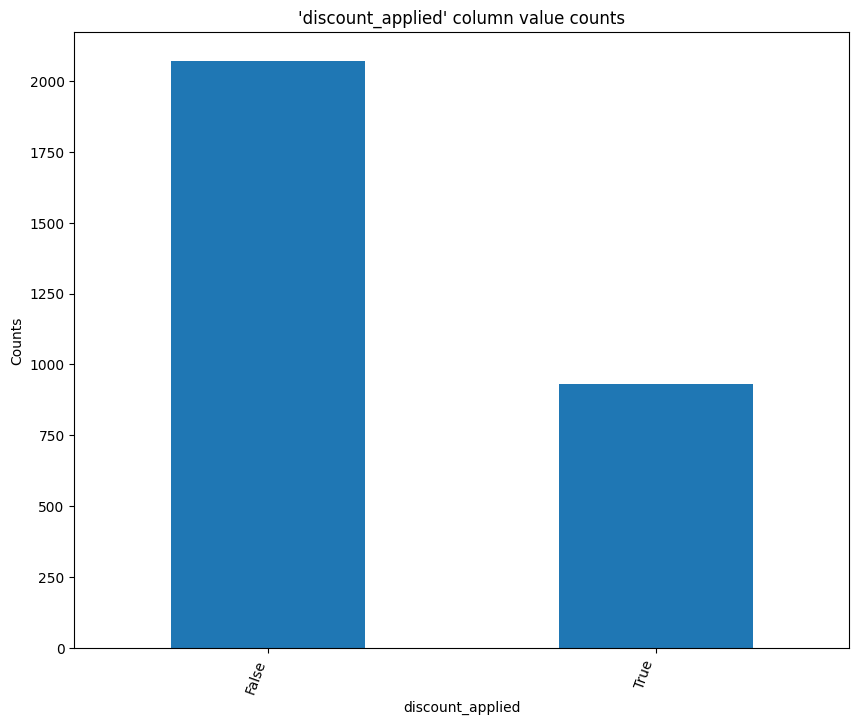

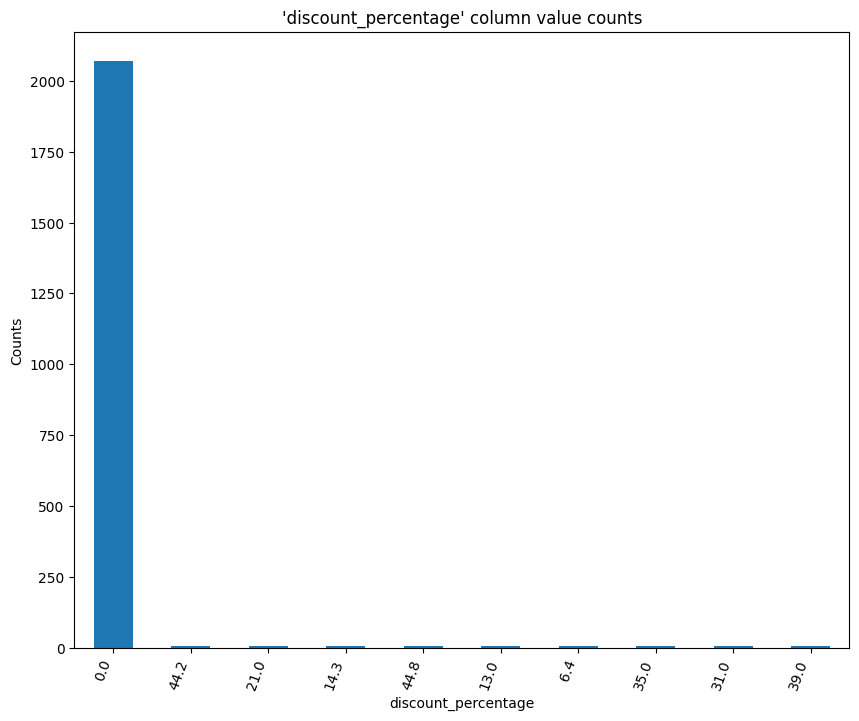

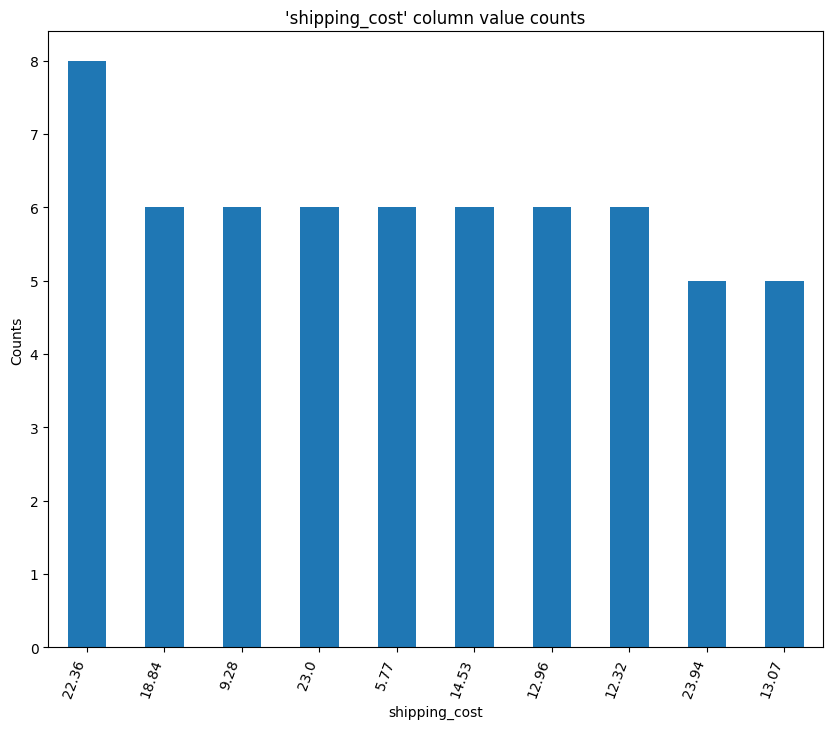

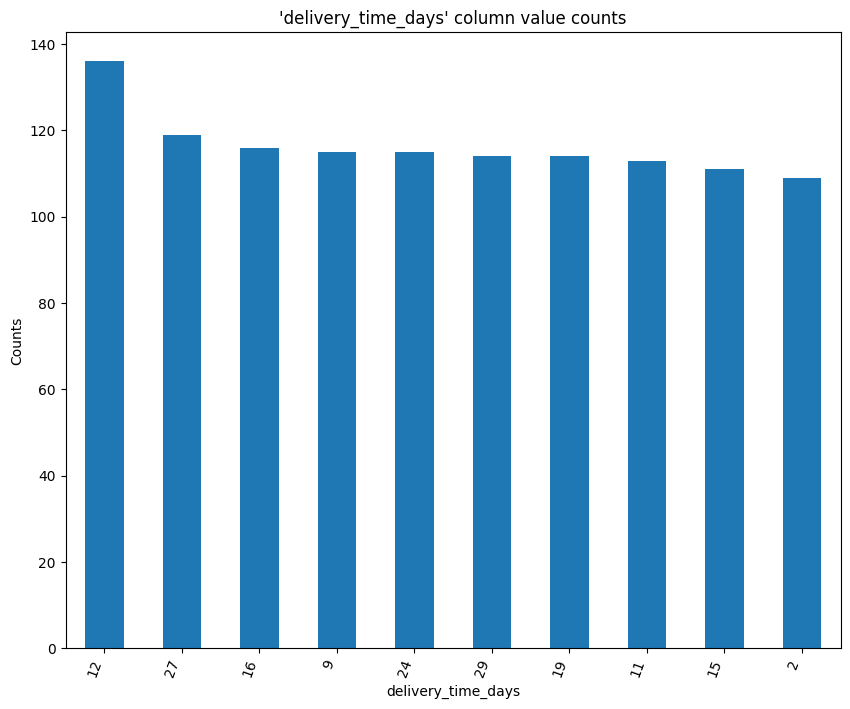

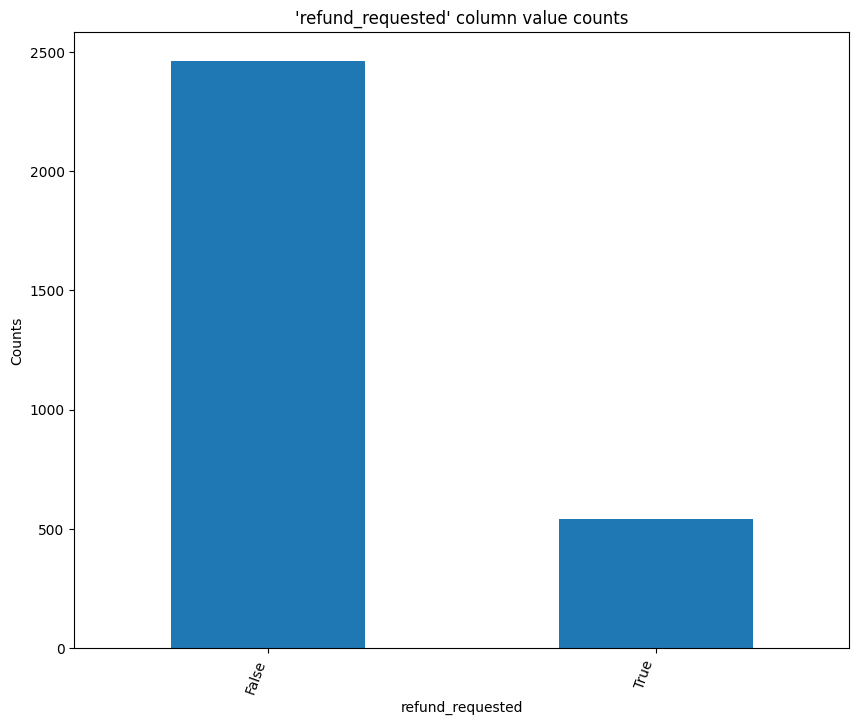

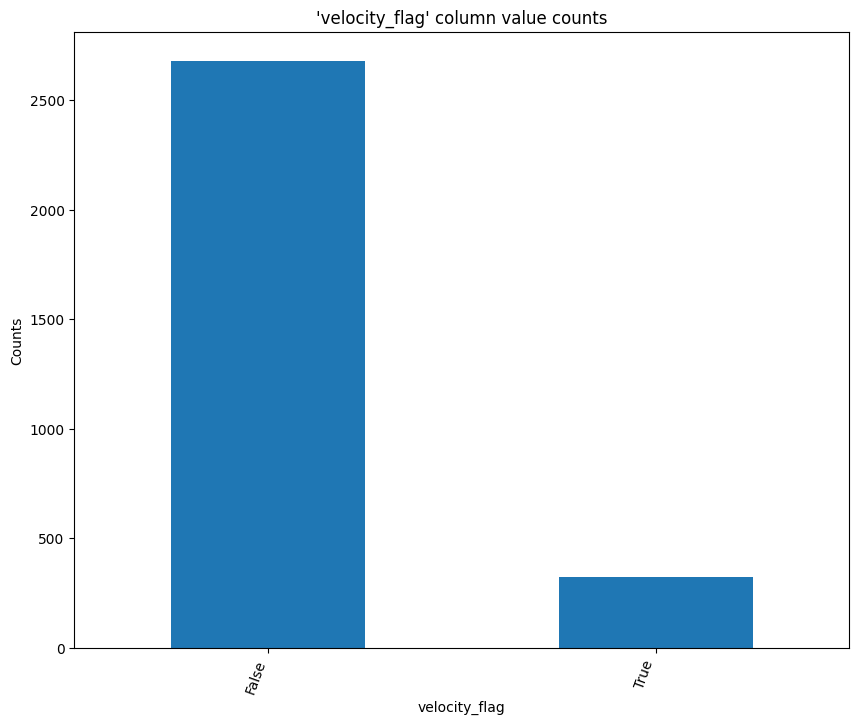

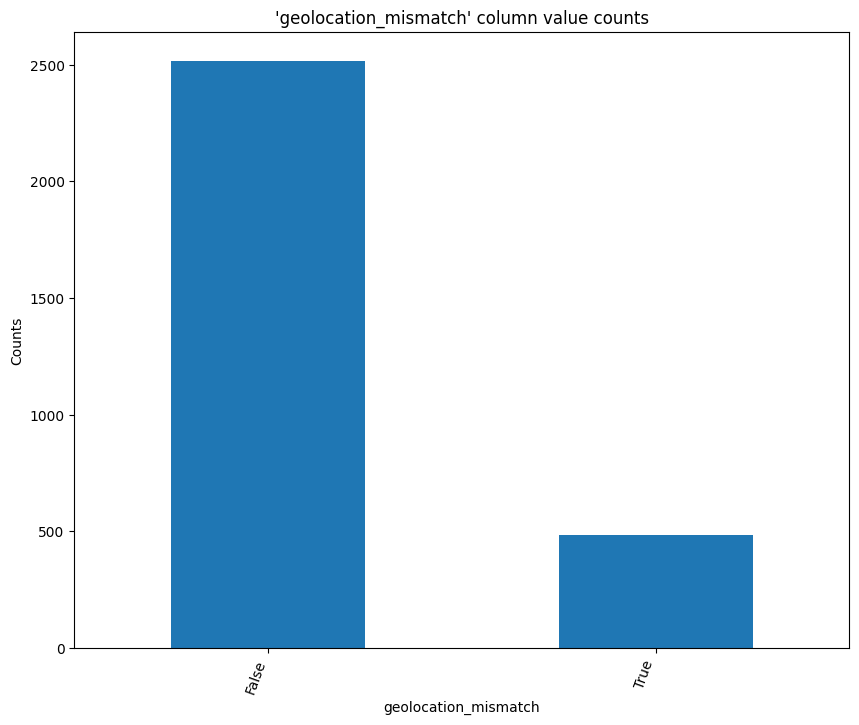

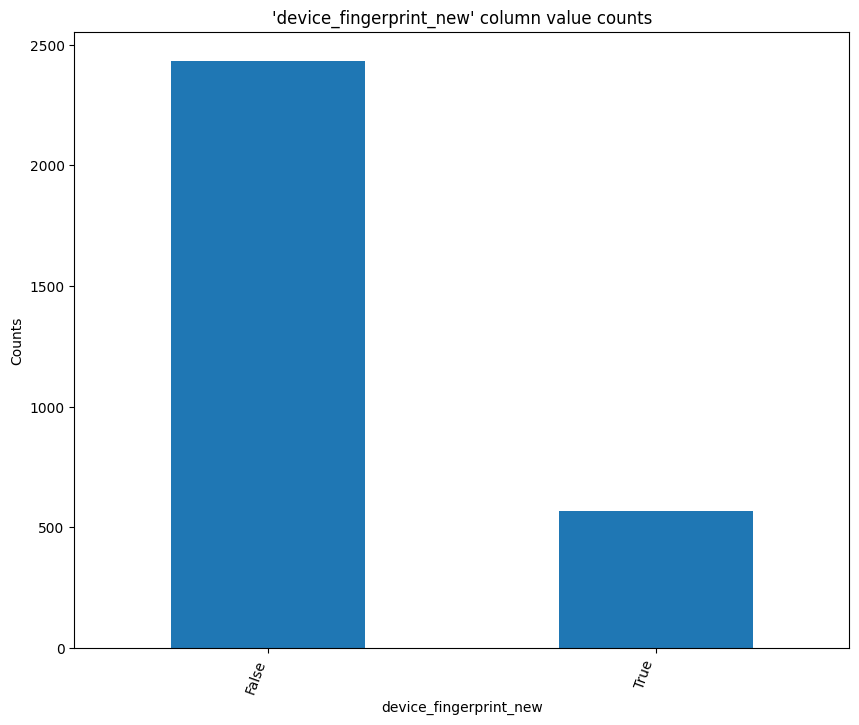

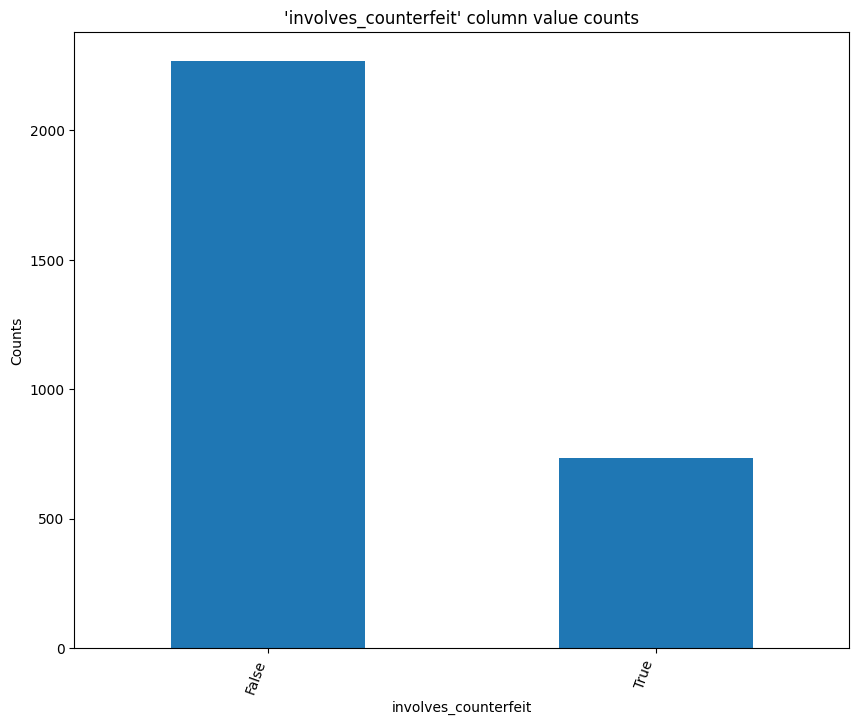

In [35]:
# Data Distribution
# Exploratory Data Analysis
def eda_plot(column, topn=10):
    plt.figure(figsize=(10, 8))
    df[column].value_counts().nlargest(topn).plot(kind='bar')
    plt.title(f"'{column}' column value counts")
    plt.ylabel("Counts")
    plt.xticks(rotation = 70, ha='right')
    plt.show()

columns = df.columns

for column in columns:
    eda_plot(column)

### checking outliers 1 by 1

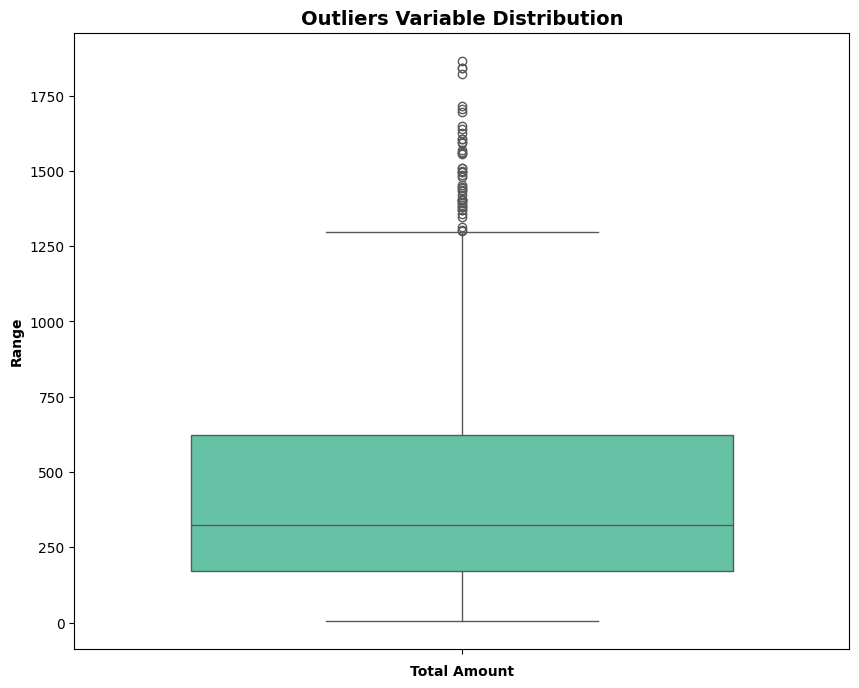

In [34]:
plt.rcParams['figure.figsize'] = [10,8]

sns.boxplot(data = df['total_amount'], orient="v", palette="Set2", 
            whis=1.5,saturation=1, width=0.7)

plt.title("Outliers Variable Distribution", fontsize = 14, fontweight = 'bold')
plt.ylabel("Range", fontweight = 'bold')
plt.xlabel("Total Amount", fontweight = 'bold');

#### As you can see there are a lot of outliers present in the total amount col,
#### now we'll address those using interquantile method

In [38]:
# Removing (statistical) outliers for any column one by one
Q1 = df.total_amount.quantile(0.25)
Q3 = df.total_amount.quantile(0.75)
IQR = Q3 - Q1
print(f"Shape {df.shape} with Outliers")
df = df[(df.total_amount >= Q1 - 1.5 * IQR) & (df.total_amount <= Q3 + 1.5 * IQR)]
print(f"Shape {df.shape} without Outliers")  

Shape (2945, 15) with Outliers
Shape (2944, 15) without Outliers


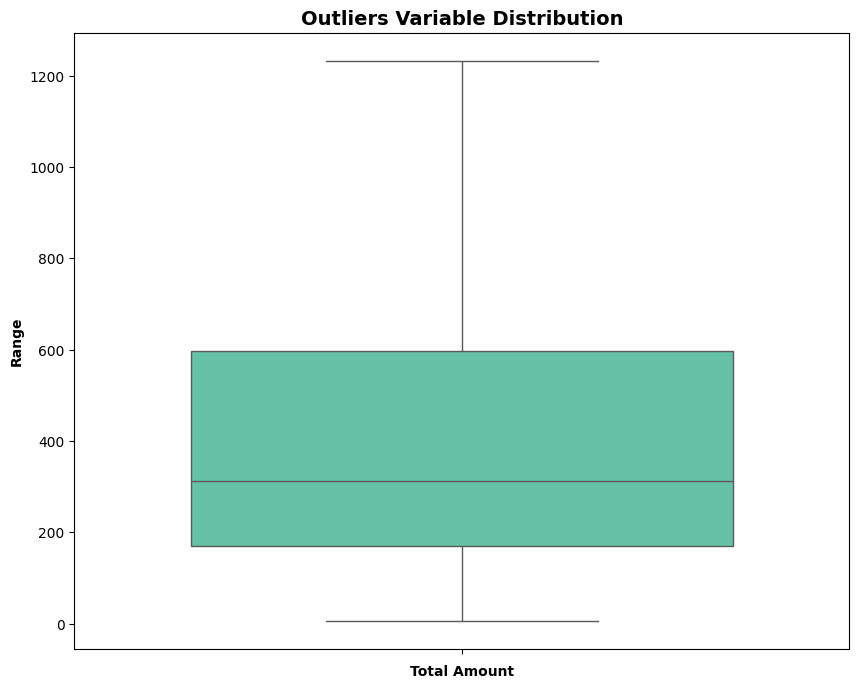

In [39]:
plt.rcParams['figure.figsize'] = [10,8]
sns.boxplot(data = df['total_amount'], orient="v", 
            palette="Set2" ,whis=1.5,saturation=1, width=0.7)

plt.title("Outliers Variable Distribution", fontsize = 14, fontweight = 'bold')
plt.ylabel("Range", fontweight = 'bold')
plt.xlabel("Total Amount", fontweight = 'bold');

#### Now the total_amount column is clean, let's proceed to perfom preprocessing

In [40]:
df.head()

,customer_age,customer_location,total_amount,payment_method,shipping_speed,customer_history_orders,discount_applied,discount_percentage,shipping_cost,delivery_time_days,refund_requested,velocity_flag,geolocation_mismatch,device_fingerprint_new,involves_counterfeit
0,22,JP,199.66,Debit Card,Express,17,False,0.0,5.39,26,False,False,False,False,False
1,62,DE,464.03,PayPal,Express,36,False,0.0,8.18,25,False,False,False,False,False
2,75,DE,42.04,Credit Card,Priority,21,False,0.0,8.61,27,False,False,False,False,False
3,56,BR,443.08,Credit Card,Standard,14,True,48.7,17.00,26,False,False,False,False,False
4,19,IN,162.80,PayPal,Priority,48,False,0.0,20.53,1,False,False,True,False,False


In [41]:
df.shape

(2944, 15)

In [42]:
# I used this to create the is_fraud column
2944 / 2 

1472.0

In [43]:
data = np.array([1] * 1472 + [0] * 1472)
np.random.shuffle(data)

In [44]:
len(data)

2944

In [45]:
# turning data to df format 
new_col = pd.DataFrame(data=data)
new_col.head()

,0
0,0
1,0
2,0
3,1
4,1


In [46]:
# creating the is_fraud column 
df['is_fraud'] = new_col.values  # or new_col.reset_index(drop=True)

In [47]:
df.head()

,customer_age,customer_location,total_amount,payment_method,shipping_speed,customer_history_orders,discount_applied,discount_percentage,shipping_cost,delivery_time_days,refund_requested,velocity_flag,geolocation_mismatch,device_fingerprint_new,involves_counterfeit,is_fraud
0,22,JP,199.66,Debit Card,Express,17,False,0.0,5.39,26,False,False,False,False,False,0
1,62,DE,464.03,PayPal,Express,36,False,0.0,8.18,25,False,False,False,False,False,0
2,75,DE,42.04,Credit Card,Priority,21,False,0.0,8.61,27,False,False,False,False,False,0
3,56,BR,443.08,Credit Card,Standard,14,True,48.7,17.00,26,False,False,False,False,False,1
4,19,IN,162.80,PayPal,Priority,48,False,0.0,20.53,1,False,False,True,False,False,1


### Preprocessing 

In [48]:
# booling columns first 
bool_cols = df.select_dtypes('bool')
bool_cols

,discount_applied,refund_requested,velocity_flag,geolocation_mismatch,device_fingerprint_new,involves_counterfeit
0,False,False,False,False,False,False
1,False,False,False,False,False,False
2,False,False,False,False,False,False
3,True,False,False,False,False,False
4,False,False,False,True,False,False
...,...,...,...,...,...,...
2995,True,False,False,False,False,False
2996,False,False,False,False,True,False
2997,False,False,False,False,False,False
2998,False,False,False,False,False,False


In [50]:
# turn your boolean column names into numbers
bool_cols = df.select_dtypes('bool') 

#encoder
label_encoder = LabelEncoder()

# looping through all over the bool columns
for bool_col in bool_cols:
    df[bool_col] = label_encoder.fit_transform(df[bool_col])

In [68]:
#new_df.select_dtypes('object')

In [51]:
# obejct columns 
object_cols = df.select_dtypes('object')

for obj_col in object_cols:
    df[obj_col] = label_encoder.fit_transform(df[obj_col])

In [52]:
df.head()

,customer_age,customer_location,total_amount,payment_method,shipping_speed,customer_history_orders,discount_applied,discount_percentage,shipping_cost,delivery_time_days,refund_requested,velocity_flag,geolocation_mismatch,device_fingerprint_new,involves_counterfeit,is_fraud
0,22,7,199.66,3,1,17,0,0.0,5.39,26,0,0,0,0,0,0
1,62,3,464.03,4,1,36,0,0.0,8.18,25,0,0,0,0,0,0
2,75,3,42.04,1,2,21,0,0.0,8.61,27,0,0,0,0,0,0
3,56,1,443.08,1,3,14,1,48.7,17.00,26,0,0,0,0,0,1
4,19,6,162.80,4,2,48,0,0.0,20.53,1,0,0,1,0,0,1


In [53]:
target_names = ['0', '1'] # In case you want to use it into the classification_report(target_names=target_names) metric

### In this case I had to create the is fraud column to perform machine learning 

### RandomForestClassifier

In [54]:
X = df.drop(columns=['is_fraud'], axis=1)
y = df['is_fraud']

# Print dataset information
print("Dataset shape:", X.shape)
print("Feature names:", X.columns)
print(f"Number of classes: {len(np.unique(y))}")
print(f"Class distribution: {np.bincount(y)}")
print() 

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("X Train shape:", X_train.shape)
print("Y Train shape:", y_train.shape)
print("X Test shape:",  X_test.shape)
print("Y Test shape:",  y_test.shape)
print("-" * 127)  

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# instantie model
rf_base = RandomForestClassifier(random_state=0)
rf_base.fit(X_train_scaled, y_train)

# prediction
y_pred_base = rf_base.predict(X_test_scaled)
y_pred_train_base = rf_base.predict(X_train_scaled)

# metrics accuracy_score
print("--- Baseline Random Forest Results ---")
print(f"Accuracy Test Score: {accuracy_score(y_test, y_pred_base):.4f}")
print(f"Accuracy Train Score: {accuracy_score(y_train, y_pred_train_base):.4f}")
print("-" * 127)   

# metrics Classification Report
print(f'Classification Report Test:\n {classification_report(y_test, y_pred_base)}')
print(f'Classification Report Train:\n {classification_report(y_train, y_pred_train_base)}')

Dataset shape: (2944, 15)
Feature names: Index(['customer_age', 'customer_location', 'total_amount', 'payment_method',
       'shipping_speed', 'customer_history_orders', 'discount_applied',
       'discount_percentage', 'shipping_cost', 'delivery_time_days',
       'refund_requested', 'velocity_flag', 'geolocation_mismatch',
       'device_fingerprint_new', 'involves_counterfeit'],
      dtype='object')
Number of classes: 2
Class distribution: [1472 1472]

X Train shape: (2355, 15)
Y Train shape: (2355,)
X Test shape: (589, 15)
Y Test shape: (589,)
-------------------------------------------------------------------------------------------------------------------------------
--- Baseline Random Forest Results ---
Accuracy Test Score: 0.5433
Accuracy Train Score: 1.0000
-------------------------------------------------------------------------------------------------------------------------------
Classification Report Test:
               precision    recall  f1-score   support

        

### BaggingClassifier

In [31]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Create a base classifier (Decision Tree in this case)
base_clf = DecisionTreeClassifier(random_state=0)

# Create and train a simple BaggingClassifier with default parameters
bag_clf = BaggingClassifier(estimator=base_clf, random_state=0)
bag_clf.fit(X_train_scaled, y_train)

# Evaluate initial model
y_pred = bag_clf.predict(X_test_scaled)
y_pred_train = bag_clf.predict(X_train_scaled)

# metrics accuracy_score
print("\n--- Baseline Bagging Classifier Results ---")
print(f"Accuracy Test Score: {accuracy_score(y_test, y_pred):.4f}")
print(f"Accuracy Train Score: {accuracy_score(y_train, y_pred_train):.4f}")

# metrics Classification Report
print("\nClassification Report:\n")
print(f'Classification Report Test:\n {classification_report(y_test, y_pred)}')
print(f'Classification Report Train:\n {classification_report(y_train, y_pred_train)}')


--- Baseline Bagging Classifier Results ---
Accuracy Test Score: 0.4890
Accuracy Train Score: 0.9885

Classification Report:

Classification Report Test:
               precision    recall  f1-score   support

           0       0.50      0.57      0.53       303
           1       0.47      0.40      0.43       286

    accuracy                           0.49       589
   macro avg       0.49      0.49      0.48       589
weighted avg       0.49      0.49      0.49       589

Classification Report Train:
               precision    recall  f1-score   support

           0       0.98      0.99      0.99      1169
           1       0.99      0.98      0.99      1186

    accuracy                           0.99      2355
   macro avg       0.99      0.99      0.99      2355
weighted avg       0.99      0.99      0.99      2355



### HistGradientBoostingClassifier

In [32]:
# Create a baseline HistGradientBoostingClassifier with default parameters
hist_gbc = HistGradientBoostingClassifier(random_state=0)
hist_gbc.fit(X_train_scaled, y_train)

# Evaluate initial model
y_pred = hist_gbc.predict(X_test_scaled)
y_pred_train = hist_gbc.predict(X_train_scaled)

# metrics accuracy_score
print("\n--- Baseline Hist Gradient Boosting Classifier Results ---")
print(f"Accuracy Test Score: {accuracy_score(y_test, y_pred):.4f}")
print(f"Accuracy Train Score: {accuracy_score(y_train, y_pred_train):.4f}")

# metrics Classification Report
print("\nClassification Report:\n")
print(f'Classification Report Test:\n {classification_report(y_test, y_pred)}')
print(f'Classification Report Train:\n {classification_report(y_train, y_pred_train)}')


--- Baseline Hist Gradient Boosting Classifier Results ---
Accuracy Test Score: 0.4601
Accuracy Train Score: 0.9703

Classification Report:

Classification Report Test:
               precision    recall  f1-score   support

           0       0.47      0.43      0.45       303
           1       0.45      0.49      0.47       286

    accuracy                           0.46       589
   macro avg       0.46      0.46      0.46       589
weighted avg       0.46      0.46      0.46       589

Classification Report Train:
               precision    recall  f1-score   support

           0       0.97      0.97      0.97      1169
           1       0.97      0.97      0.97      1186

    accuracy                           0.97      2355
   macro avg       0.97      0.97      0.97      2355
weighted avg       0.97      0.97      0.97      2355



### XGBClassifier

In [35]:
xg_cl = XGBClassifier(objective='binary:logistic', n_estimators=10, seed=123)
xg_cl.fit(X_train_scaled, y_train)

y_pred = xg_cl.predict(X_test_scaled)
y_pred_train = xg_cl.predict(X_train_scaled) 

# metrics accuracy_score
accuracy_test = float(np.sum(y_pred == y_test)) / y_test.shape[0]
accuracy_train = float(np.sum(y_pred_train == y_train)) / y_test.shape[0]
print("accuracy test: %f" % (accuracy_test))
print("accuracy train: %f" % (accuracy_train))

# metrics Classification Report
print("\nClassification Report:\n")
print(f'Classification Report Test:\n {classification_report(y_test, y_pred)}')
print(f'Classification Report Train:\n {classification_report(y_train, y_pred_train)}')

accuracy test: 0.511036
accuracy train: 3.193548

Classification Report:

Classification Report Test:
               precision    recall  f1-score   support

           0       0.53      0.50      0.51       303
           1       0.50      0.52      0.51       286

    accuracy                           0.51       589
   macro avg       0.51      0.51      0.51       589
weighted avg       0.51      0.51      0.51       589

Classification Report Train:
               precision    recall  f1-score   support

           0       0.79      0.81      0.80      1169
           1       0.81      0.79      0.80      1186

    accuracy                           0.80      2355
   macro avg       0.80      0.80      0.80      2355
weighted avg       0.80      0.80      0.80      2355



### GradientBoostingClassifier

In [41]:
# Create a pipeline with preprocessing and model
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', GradientBoostingClassifier(random_state=42))
])

# 1. Basic model with default parameters
print("\n1. INITIAL MODEL WITH DEFAULT PARAMETERS")
model = pipeline
model.fit(X_train_scaled, y_train)

y_pred = model.predict(X_test_scaled)
y_pred_train = model.predict(X_train_scaled)

print(f"Accuracy on test set: {accuracy_score(y_test, y_pred):.4f}")
print(f"Accuracy on train set: {accuracy_score(y_train, y_pred_train):.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print(classification_report(y_train, y_pred_train))


1. INITIAL MODEL WITH DEFAULT PARAMETERS
Accuracy on test set: 0.4975
Accuracy on train set: 0.7418

Classification Report:
              precision    recall  f1-score   support

           0       0.51      0.49      0.50       303
           1       0.48      0.50      0.49       286

    accuracy                           0.50       589
   macro avg       0.50      0.50      0.50       589
weighted avg       0.50      0.50      0.50       589

              precision    recall  f1-score   support

           0       0.73      0.75      0.74      1169
           1       0.75      0.73      0.74      1186

    accuracy                           0.74      2355
   macro avg       0.74      0.74      0.74      2355
weighted avg       0.74      0.74      0.74      2355



## ML models for banking systems

### GaussianNB

In [45]:
gnb = GaussianNB()
gnb.fit(X_train_scaled, y_train)

y_pred = gnb.predict(X_test_scaled)
y_pred_train = gnb.predict(X_train_scaled)
    
print(f"Accuracy test set: {accuracy_score(y_test, y_pred):.3f}")
print(f"Accuracy train set: {accuracy_score(y_train, y_pred_train):.3f}")
print(f"Classes: {gnb.classes_}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print(classification_report(y_train, y_pred_train))

Accuracy test set: 0.520
Accuracy train set: 0.548
Classes: [0 1]

Classification Report:
              precision    recall  f1-score   support

           0       0.53      0.60      0.56       303
           1       0.51      0.43      0.47       286

    accuracy                           0.52       589
   macro avg       0.52      0.52      0.51       589
weighted avg       0.52      0.52      0.52       589

              precision    recall  f1-score   support

           0       0.54      0.60      0.57      1169
           1       0.56      0.50      0.52      1186

    accuracy                           0.55      2355
   macro avg       0.55      0.55      0.55      2355
weighted avg       0.55      0.55      0.55      2355



### LogisticRegression

In [49]:
# Create a pipeline with preprocessing and logistic regression
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Scale features
    ('classifier', LogisticRegression(random_state=0))  # Logistic regression model
])

# Basic model with default parameters
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)
y_pred_train = pipeline.predict(X_train)

# Evaluate the basic model
print("\n--- Basic Model Performance ---")
print(f"Accuracy test set: {accuracy_score(y_test, y_pred):.4f}")
print(f"Accuracy train set: {accuracy_score(y_train, y_pred_train):.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print(classification_report(y_train, y_pred_train))

# Display confusion matrix
#print("\nConfusion Matrix:")
print(f'Confusion Matrix test set:\n {confusion_matrix(y_test, y_pred)}')
print(f'Confusion Matrix test set:\n {confusion_matrix(y_train, y_pred_train)}')


--- Basic Model Performance ---
Accuracy test set: 0.4686
Accuracy train set: 0.5448

Classification Report:
              precision    recall  f1-score   support

           0       0.48      0.49      0.49       303
           1       0.45      0.45      0.45       286

    accuracy                           0.47       589
   macro avg       0.47      0.47      0.47       589
weighted avg       0.47      0.47      0.47       589

              precision    recall  f1-score   support

           0       0.54      0.54      0.54      1169
           1       0.55      0.54      0.55      1186

    accuracy                           0.54      2355
   macro avg       0.54      0.54      0.54      2355
weighted avg       0.54      0.54      0.54      2355

Confusion Matrix test set:
 [[148 155]
 [158 128]]
Confusion Matrix test set:
 [[637 532]
 [540 646]]


### DecisionTreeClassifier

In [50]:
### Tuning Example

# Define parameter grid
param_grid = {
    'max_depth': [None, 5, 10, 15, 20],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 4, 8],
    'criterion': ['gini', 'entropy']
}

# Create model
dt = DecisionTreeClassifier(random_state=0)

# Perform grid search with 5-fold cross-validation
grid_search = GridSearchCV(dt, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train_scaled, y_train)

# Best parameters and score
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validation score: {grid_search.best_score_:.4f}")

# Best model
best_dt = grid_search.best_estimator_
print(best_dt)

Best parameters: {'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 10}
Best cross-validation score: 0.5210
DecisionTreeClassifier(min_samples_leaf=4, min_samples_split=10, random_state=0)


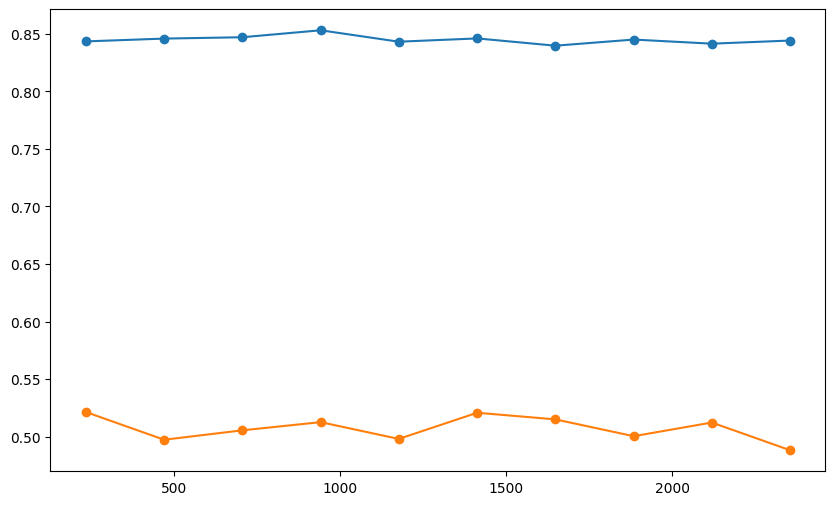

In [53]:
from sklearn import tree
import matplotlib.pyplot as plt

# Plot tree
#plt.figure(figsize=(20, 10))
#tree.plot_tree(grid_search.best_estimator_, filled=True)

# Plot learning curves to detect overfitting
from sklearn.model_selection import learning_curve
train_sizes, train_scores, test_scores = learning_curve(
    grid_search.best_estimator_, X, y, cv=5, n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10))

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, np.mean(train_scores, axis=1), 'o-', label='Training score')
plt.plot(train_sizes, np.mean(test_scores, axis=1), 'o-', label='Cross-validation score')
plt.show()

### SVC

In [57]:
svc = SVC()
svc.fit(X_train_scaled, y_train)

# Basic model with default parameters
y_pred = svc.predict(X_test)
y_pred_train = svc.predict(X_train)

# Evaluate the basic model
print("\n--- Basic Model Performance ---")
print(f"Accuracy test set: {accuracy_score(y_test, y_pred):.4f}")
print(f"Accuracy train set: {accuracy_score(y_train, y_pred_train):.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print(classification_report(y_train, y_pred_train))

# Display confusion matrix
#print("\nConfusion Matrix:")
print(f'Confusion Matrix test set:\n {confusion_matrix(y_test, y_pred)}')
print(f'Confusion Matrix test set:\n {confusion_matrix(y_train, y_pred_train)}')


--- Basic Model Performance ---
Accuracy test set: 0.4856
Accuracy train set: 0.5036

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       303
           1       0.49      1.00      0.65       286

    accuracy                           0.49       589
   macro avg       0.24      0.50      0.33       589
weighted avg       0.24      0.49      0.32       589

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1169
           1       0.50      1.00      0.67      1186

    accuracy                           0.50      2355
   macro avg       0.25      0.50      0.33      2355
weighted avg       0.25      0.50      0.34      2355

Confusion Matrix test set:
 [[  0 303]
 [  0 286]]
Confusion Matrix test set:
 [[   0 1169]
 [   0 1186]]
